# Putting the 3 chapters together...

In [1]:
### Importing packages and functions
import sys
import os

In [2]:
#os.environ['AUTO_DIR'] = './auto2/auto-07p'

In [3]:
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [4]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [5]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [6]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [7]:
def saving_pdf_figure(fig,fig_name,md_dir):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    ax.savefig(fig_name+'.png',dpi=200)
    fig.savefig(pdffig, format="pdf")
    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [8]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [9]:
def zoomingBox_4PhasePlane(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    src = [3, 1]; dst = [2, 0]
#     if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
#         src = [0, 3]; dst = [0, 3]
#     elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
#         src = [1, 2]; dst = [1, 2]
#     elif dstBB.max[1] < srcBB.min[1]:
#         src = [0, 2]; dst = [1, 3]
#     elif dstBB.min[1] > srcBB.max[1]:
#         src = [1, 3]; dst = [0, 2]
#     elif dstBB.max[0] < srcBB.min[0]:
#         src = [0, 1]; dst = [2, 3]
#     elif dstBB.min[0] > srcBB.max[0]:
#         src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [10]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [11]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
from copy import copy
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto
def get_expressions(neuron_snap,bifpar,autobifpart={}):
    from copy import copy
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    return var,rhs,spikecriterion,J


# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    from copy import copy
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals


# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

def extracting_left_eigenvectors(ss,lc,bifpar={}):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_saddle_point=[]
    v_I_app_ss=[]
    for ao_saddle_point in ss:
        bifparX={}
        for ii_s in list(bifpar.keys()):
            bifparX[ii_s]=str(ao_saddle_point.PAR[ii_s])+bifpar[ii_s][0][bifpar[ii_s][0].index('*'):-1]
        var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifparX)
        ### Getting position
        saddle_point=ao_saddle_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_saddle_point.coordnames,J)
        Jmat=Jfoo(*saddle_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(np.matrix(m_JMat).transpose())
        v_saddle_point.append(saddle_point)
        v_Jeival.append(copy(Jeival))
        v_Jeivect.append(copy(Jeivect))
        v_I_app_ss.append(ao_saddle_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_saddle_point,m_JMat

def extracting_phase_plane_info(ss,lc,bifpar={}):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_fixed_point=[]
    v_I_app_ss=[]
    for ao_fixed_point in ss:
        bifparX={}
        for ii_s in list(bifpar.keys()):
            bifparX[ii_s]=str(ao_fixed_point.PAR[ii_s])+bifpar[ii_s][0][bifpar[ii_s][0].index('*'):-1]
        var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifparX)
        ### Getting position
        fixed_point=ao_fixed_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_fixed_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_fixed_point.coordnames,J)
        Jmat=Jfoo(*fixed_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(m_JMat)
        v_fixed_point.append(fixed_point)
        v_Jeival.append(Jeival)
        v_Jeivect.append(Jeivect)
        v_I_app_ss.append(ao_fixed_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point

def get_normalized_PRC(model_name,bifpar,v_one_sim_s_lc,limit_cycle):
    import brian2
    import brianutils
    from brianutils import units
    from brianutils import load_model
    ## to calculate PRC Z_o(\varphi)
    ### loading ODE from model_name with parameters given in bifpar
    model= json.load(open("./cfg/"+model_name+".json"))
    if bifpar!=[]:
        for key_bifpar in bifpar.keys():
            model['parameters'][key_bifpar]=bifpar[key_bifpar][0]
    
    ode = load_model(model, {})
    ### Initializing the orbit in the stable limit cycle
    d_ini_states=model['init_states']
    cc_k=0
    for k in v_one_sim_s_lc[0]:
        if k=='v':
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])+'*mV'
        else:
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])
        cc_k+=1
    
    orb0= brianutils.flow(ode,".5*second",init=d_ini_states,dt="0.01*ms")
    var=ode.diff_eq_names
    inistates=dict([(si_var,'('+str(orb0[si_var][-1][0])+')') for si_var in var])
    ### Changing initial states to the correct format
    jj=[ii for ii in inistates if 'mV' in inistates[ii]]
    vv=inistates[jj[0]].find('mV')
    inistates[jj[0]]=inistates[jj[0]][0:vv-1]+'*'+inistates[jj[0]][vv:]
    ## Running the trace for shorter time, but starting in a sequred a steady state
    orb= brianutils.flow(ode,".3*second",init=inistates,dt="0.001*ms")
    ## Getting a solution to the adjoint first variation of an ODE
    adstates=brianutils.adjoint_linear_flow(ode,".3*second",init=inistates,dt="0.001*ms")
    ## Finding indices where there where spikes
    spk_indices=brianutils.get_spikeIndices(orb["v"], threshold = "-30 * mV")
    av_period=np.mean(np.diff(orb['t'][spk_indices]))
    indexRange=[spk_indices[int(len(spk_indices)/2)],spk_indices[int(len(spk_indices)/2)+1]]
    #### Importing units to substitute later..
    baseunits2 = [('mV', 1), ('ms', 1),('second', 1), ('cm2', 1), ('cm3', 1), ('uF', 1), ('psiemens', 1), ('um2', 1), ('msiemens', 1), ('cm', 1), ('kelvin', 1), ('mM', 1), ('mol', 1), ('uA', 1), ('mjoule', 1), ('coulomb',1), ('ufarad',1), ('mvolt',1)]
    units= dict(
                list(vars(brian2.units).items())
               +list(vars(brian2.units.allunits).items())
               +list(vars(brian2.units.fundamentalunits).items())
               )
    ##### Getting the right hand side expressions to calculate f(x)
    var,rhs= zip(*ode.eq_expressions)
    sortedOrb = [orb[variable] for variable in var]
    sortedOrb[var.index("v")] = sortedOrb[var.index("v")]/eval("1 * mV",units)  # add additional variable with normalized voltage dimension to fit the replacement {'v/mV':additionalVar} done below
    rhsEvaluatedDict = {}
    for i, equ in enumerate(rhs):
        equStr = str(sympy.S(equ).subs(baseunits2))
        equFct = sympy.lambdify(var, S(equStr))
        rhsEvaluatedDict[var[i]] =np.array([value for value in equFct(*sortedOrb)])      # the star unpacks list into separate python variables. brian2.Quantities ensures that units are kept
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    variable='v'
    reducedFlow[variable]=reducedFlow[variable]/eval("1 * mV",units)
    reducedAdjoint["ad"+variable]=reducedAdjoint["ad"+variable]*eval("1 * mV",units)
    ## Calculating z(\phi)f(x)
    rhsEvaluated=rhsEvaluatedDict
    ZdotF = np.zeros(rhsEvaluated[variable][:,0].shape) * (reducedAdjoint["ad"+variable][0] * rhsEvaluated[variable][0])
    for variable in ode.eq_names:
        # this implements a dot product over the different state variables for every time point.
        ZdotF += reducedAdjoint["ad"+variable] * rhsEvaluated[variable][:,0]     # returns ZdotF depending on time
    #     print(variable, reducedAdjoint["ad"+variable][:3], rhsEvaluated[variable][:3], ZdotF[:3])
    
    print("Check: Are the following values all eqaul? ZdotF = ", ZdotF[::len(ZdotF)//30]) # those values should all be the same, but the first and last values are different
    periodUnitless = av_period/eval("1 * ms",units)
    ZdotFunitless = ZdotF
    ZdotFvalue = np.mean(ZdotFunitless[int(len(ZdotF)*0.3):int(len(ZdotF)*0.6)])
    PRC = {}
    for key in ode.eq_names:
        PRC[key] = reducedAdjoint["ad"+key][indexRange[0]:indexRange[1]]/(ZdotFvalue*periodUnitless)
    return PRC,periodUnitless,ZdotF,reducedFlow,reducedAdjoint,ode

In [12]:

def run_model_w_brian_long(model_file,axi=[],bifparx=[],num_neurons=1,connected=0,p_e=[],p_i=[],ge_amp=[],gi_amp=[],w_zoomin2_v=[],showfig=0):
    from brian2 import units
    units = vars(units)
    model = json.load(open(model_file))
    if bifparx!=[]:
        for key_bifpar in bifparx.keys():
            model['parameters'][key_bifpar]=bifparx[key_bifpar][0]
    model_equations = load_model(model, {})
    brian2.prefs.codegen.target = 'cython'
    simulation_duration = time_stim * ms
    dt = resol* ms
    brian2.defaultclock.dt = dt
    error = 1.e-6
    method_options = {'save_step_count': True,
                  'absolute_error': error,
                  'max_steps': 10000}
    neuron = brian2.NeuronGroup(num_neurons, model=model_equations, method='gsl_rk2',method_options=method_options,threshold='v>10*mV',refractory=0.5*ms)
    ### Setting initial conditions
    s_state_vars=[]
    for s_state_var_i in model['init_states'].keys():
        if s_state_var_i!='v':
            st=eval(model["init_states"][s_state_var_i],units)
            setattr(neuron,s_state_var_i,copy(st))
        s_state_vars.append(s_state_var_i)
    
    if connected==1:
        Pe = neuron[:int(num_neurons/2)]
        Pi = neuron[int(num_neurons/2):]
        if ge_amp==[]:
            Ce = Synapses(Pe, neuron, on_pre='ge+=0.162*mV')
        else:
            Ce = Synapses(Pe, neuron, on_pre='ge+='+str(ge_amp)+'*mV')
        if p_e==[]:
            Ce.connect(p=0.02)
        else:
            Ce.connect(p=p_e)
        if gi_amp==[]:
            Ci = Synapses(Pi, neuron, on_pre='gi-=0.9*mV')
        else:
            Ci = Synapses(Pi, neuron, on_pre='gi-='+str(gi_amp)+'*mV')
        if p_i==[]:
            Ci.connect(p=0.02)
        else:
            Ci.connect(p=p_i)

    ##### Introducing some variability to initial conditions
    
    vr = eval("-75*mV",units)
    vt0 = eval("-65*mV",units)
    neuron.v='rand()*(vt0-vr)+vr'
    ##### Running for 150ms without recording, while it reaches a steady state
    initial_time=500*ms
    start = time.time()
    if w_zoomin2_v!=[]:
        Pzoom=neuron[int(num_neurons/2-w_zoomin2_v/2):int(num_neurons/2+w_zoomin2_v/2)]
        net = Network(Pe, Pi, Ce, Ci,neuron,Pzoom)
    else:
        net = Network(Pe, Pi, Ce, Ci,neuron)

    net.run(initial_time)
    ##### Defining what to record
    spikemon = SpikeMonitor(neuron)
    LFP = PopulationRateMonitor(neuron)
    r_e = PopulationRateMonitor(Pe)
    r_i = PopulationRateMonitor(Pi)

    if num_neurons<100:
        statemon = StateMonitor(neuron, ('v'), record=True,dt=dt)
        monitors = [spikemon,LFP,r_e,r_i,statemon]
    else:
        statemon=[]

    if w_zoomin2_v==[]:
        statemonZoom=[]
        spikemonZoom=[]
        monitors = [spikemon,LFP,r_e,r_i]
    else:
        ## Monitors synaptic input s well..
        statemonZoom=StateMonitor(Pzoom,s_state_vars, record=True,dt=dt)
        spikemonZoom = SpikeMonitor(Pzoom)
        monitors = [spikemon,LFP,r_e,r_i,statemonZoom,spikemonZoom]

    net.add(monitors)
    net.run(simulation_duration)
    ## run_time is to keep track of simulation time
    spikemon.add_attribute('run_time')
    spikemon.add_attribute('ge_amp')
    spikemon.add_attribute('gi_amp')
    spikemon.ge_amp=ge_amp
    spikemon.gi_amp=gi_amp

    spikemon.run_time = time.time() - start
    ax=axi
    if axi==[] and showfig==1:
        f2, ax= plt.subplots(num_neurons, sharex=True, facecolor="1",figsize=(fig_wide,fig_height))
    else:
        f2=[]

    if showfig==1:
        for i in range(num_neurons):
            if num_neurons==1:
                ax.plot(statemon.t/ms, statemon.v[i]/mV, label='Neuron 0')
            else:
                ax[i].plot(statemon.t/ms, statemon.v[i]/mV, label='Neuron 0')

    if axi==[] and showfig==1:
        return f2,statemon,statemonZoom,spikemonZoom,spikemon,LFP, r_e,r_i, model_equations
    else:
        return ax, statemon,statemonZoom,spikemonZoom,spikemon,LFP, r_e,r_i, model_equations,[Ce.i,Ce.j],[Ci.i,Ci.j] #, Nai

In [13]:
def l0_ys0_Iapp(t_I_app_specf):
    ## Defining Bifurcation parameters.. (In our case I_app and Ko)
    bifpar={}
    autobifpart={}
    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    autobifpart[strIapp]=I_app
    bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    autobifpart['K_o']=K_o
    ### Extracting inistates & expressions
    var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
    cwd_nonTemp = os.getcwd()
    ### Calculating fixed points
    with TemporaryDirectory(suffix="trial0") as t:
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        #############################################################
        ##### Using AUTO to Continue steady state
        # Continuing Forward (ds>0) in I_app
        try:
            r1_fwd_sn_I_app_specf_0= auto.run(inivals, e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
                PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
                DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
                UZSTOP= {})

            t_I_app_specf=list(t_I_app_specf)+[r1_fwd_sn_I_app_specf_0.getLabel('LP')[0].PAR[strIapp]-0.00001]
        except:
            pass

        r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
            PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
            DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
            UZSTOP= {})

    os.chdir(cwd_nonTemp)
    ### Calculating limit cycles
    s1HB = r1_fwd_sn_I_app_specf('HB')[0]
    ################# continuing orbit #######################
    ### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
    with TemporaryDirectory(suffix="trial0") as t:
        r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
            ITNW=17, NWTN=13, NMX=50000, NPR=3000,
            #DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1
            DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
            SP=['BT','LP','HB','BP','CP'],
            UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})

    os.chdir(cwd_nonTemp)

    ## Extracting all the steady states and limit cycle onsets for the applied currents t_I_app_specf
    ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
    lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

    ## Extracting information from auto objects into numpy arrays   
    v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,rv_Jeival,rv_Jeivect,v_fixed_point=extracting_phase_plane_info(ss_I_app_specf,lc_Iapp_specf,bifpar=bifpar)
    v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point,m_Jmat=extracting_left_eigenvectors(ss_I_app_specf,lc_Iapp_specf,bifpar=bifpar)
    v_l0=[]
    v_ys_0=[]
    v_LCi=[]
    vv_saddle=[]
    vv_stable=[]
    for ii_iapi in range(len(t_I_app_specf)):
        saddle=[]
        stable=[]
        l0=[]
        ys_0=[]
        limit_cycle=[]
        for ii_api_ss in range(len(v_I_app_ss)):
            ## Extracting info from fixed points
            if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<min(abs(min(np.diff(t_I_app_specf))/2),0.01):
                if sum(v_Jeival[ii_api_ss].real>0)==1:
                    ## Extracting eigenvalues and eigenvectors at the saddle node
                    saddle=v_fixed_point[ii_api_ss]
                    El_saddle=v_Jeivect[ii_api_ss]
                    Er_saddle=rv_Jeivect[ii_api_ss]
                    lam_saddle=v_Jeival[ii_api_ss]
                if sum(v_Jeival[ii_api_ss].real>0)==0:
                    ## Extracting eigenvalues and eigenvectors at the stable fixed node
                    stable=v_fixed_point[ii_api_ss]
                    lam_stable=v_Jeival[ii_api_ss]
        
        for ii_api_lc in range(len(v_I_app_lc)):
            if abs(v_I_app_lc[ii_api_lc]-t_I_app_specf[ii_iapi])<min(abs(min(np.diff(t_I_app_specf))/2),0.01):
                limit_cycle=v_one_sim_lc[ii_api_lc]

        if len(saddle)>0:      
            argsort = [j for j, k in sorted(enumerate(lam_saddle), key=lambda x:x[1], reverse=1)]
            lam = [lam_saddle[k] for k in argsort]
            lam0=lam[0]
            ## Extracting l0 from the left eigenvectors at the saddle node
            l0=np.concatenate(np.array(El_saddle[:,lam_saddle>0]))
            ## projecting the stable fixed point and the saddle in l0
            ys_0=np.dot(l0,saddle)[0]   
            if len(stable)>0:
                yn=np.dot(l0,stable)[0]
                if yn>ys_0:
                    l0=-l0
                    ys_0=np.dot(l0,saddle)[0]
                    yn=np.dot(l0,stable)[0]

        v_l0.append(l0)
        v_ys_0.append(ys_0)
        ### Limit cycle is needed to get the reference right later.. dlc>ys
        v_LCi.append(limit_cycle)
        vv_saddle.append(saddle)
        vv_stable.append(stable)
        
    return(v_l0,v_ys_0,v_LCi,t_I_app_specf,vv_saddle,vv_stable)

In [14]:
from scipy.optimize import curve_fit

def func_lambdas(l0,bifpar,autobifpart,saddle,stable,limit_cycle):
    ################################################
    ###### Getting lambdas (eigenvalues) in each stable state (the lambda corresponding to l0..)
    ################################################
    lam_st=[]
    lam_lc=[]
    lam_0=[]

    var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifpar,autobifpart)

    if len(stable)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(stable[iic][0])
            iic+=1

        matJ_stable=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_stable[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
    
    if len(saddle)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(saddle[iic][0])
            iic+=1

        matJ_saddle=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_saddle[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
        
        if len(limit_cycle)>0:   
            ii_min=np.argmin(np.dot(l0,limit_cycle-saddle)) 
            ll=limit_cycle[:,ii_min]
    else:
        if len(limit_cycle)>0:
            if type(np.array(limit_cycle))==numpy.ndarray:
                ii_min=np.argmin(list(limit_cycle)[var=='v'])
            else:
                ii_min=np.argmin(limit_cycle[var=='v'])
                
            ll=limit_cycle[:,ii_min]

    if len(limit_cycle)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(ll[iic])
            iic+=1

        matJ_lc=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_lc[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd)

    try:
        lam_st=LA.eig(matJ_stable)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_st=[]
    try:  
        lam_lc=LA.eig(matJ_lc)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_lc=[]
    try:
        lam_0=LA.eig(matJ_saddle)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_0=[]

    
    return lam_0,lam_st,lam_lc

In [15]:
def _2Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2))) +\
           amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen2)**2)/((2*sigma2)**2)))


def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2))) 


# First.. chapter 1: Bif Graph

### Defining neuron model

In [16]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Extracting Bif graph information from saved object

In [17]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

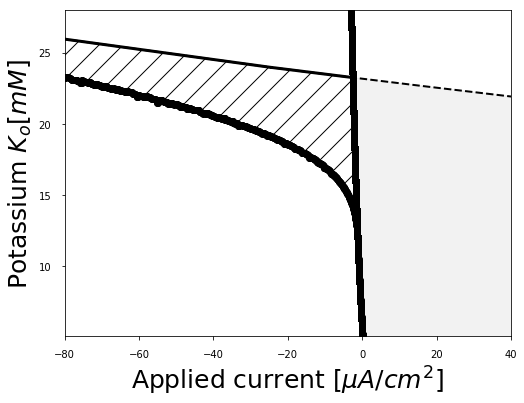

In [18]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('Potassium $K_o[mM]$',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()


# Second.. chapter 3: Sparsly connected networks

## Loading simulation s for different Ko's and extracting stats

In [19]:
fig_wide=12
fig_height=10
size_title_font=20
size_axis_font=20
matplotlib.rc('font', family='sans-serif', size=size_axis_font)


INFO       Cache size for target "cython": 9924 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/contreras/.cython/brian_extensions" directory. [brian2]


d_Network_N_4000_num_runs_1_lengthSim_20000K_o_8_I_app_34ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}


WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:207: RuntimeWarning: divide by zero encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


d_Network_N_4000_num_runs_1_lengthSim_20000K_o_9_I_app_30ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['3.09501356* uA/cm2'], 'K_o': ['(9.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
this file doesnt exist.. :(  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_10_I_app_27ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas
d_Network_N_4000_num_runs_1_lengthSim_20000K_o_11_I_app_23ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['2.34713872* uA/cm2'], 'K_o': ['(11.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
d_Network_N_4000_num_runs_1_lengthSim_20000K_o_12_I_app_18ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_nu

WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
 [py.warnings]


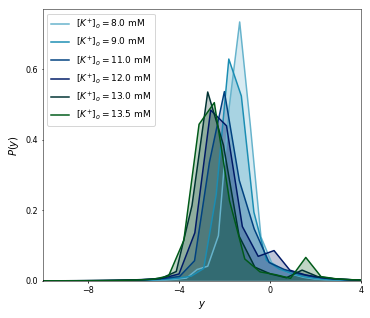

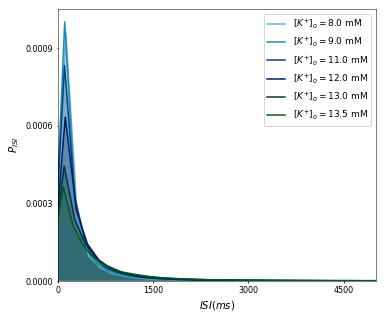

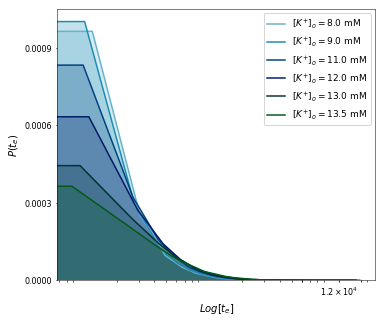

In [20]:
from scipy import signal
from scipy.fftpack import fft
import brian2
from brian2.units import *
from brian2 import *
from brianutils import load_model
resol=0.01#ms (min resolution of integration)
from brian2 import units
### For plotting the histograms...
import pandas as pd
import seaborn as sns
from scipy import stats
lss_than=10000


units = vars(units)

num_neurons=2000
ge_amp=0.035
gi_amp=0.27
koivv=[8,9,10,11.0,12.0,12.5,13.0, 13.5]
si_v=[1.0]### sigma for white noise approximation..
i_siiv=0
koivv2=np.array(koivv)
# iapi_v=np.array(mu_fr_vect)

iapi_v=np.array([3.44756179, 3.09501356, 2.72745491, 2.34713872, 1.88336673,
       1.64088176, 1.31921738, 0.9238477 ])

# ### Will take as an example Ko 9.5 to see if the deltaU scales with T..
# 1. load network data
dir_SIMS=[]
# conds
time_stim=20000

##############################################################333
########### One Run..
model_file='/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'
dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
ckoi=0

### extract input
a_bw_pos_pop=[]
a_aw_pos_pop=[]
###Theor input
v_sigma_input_pop=[]
v_mu_input_pop=[]
v_input_bw_pos_pop_theor=[]
v_Dist_theor=[]
### A_y
m_hist_a_a_y=[]
m_hist_b_a_y=[]
### U_y
m_hist_a_Uy=[]
m_hist_b_Uy=[]
m_sig_proj_Uy=[]
## Escape rate
v_T0x=[]
m_mean_ISI=[]
## Actual simulations.. (not every value has long sim)
v_Ko_t=[]
v_iKo_t=[]

p_lfp_v=[]
f_lfp_v=[]

import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))
f21, ax1= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))
f22, ax2= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))


cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)

for K_o in koivv2:
    colorii=next(colors)
    iapi=iapi_v[ckoi]
    bifparx={}

    ge_amp=0.035
    gi_amp=0.27
    ############# Creating Fancy name to understand simulations later
    num_runs=1
    ii_num_realizations_4_smooth=1
    num_neurons=4000
    bifparx["I_app"]=[str(iapi)+"* uA/cm2"]#0.87 for low and -0.68 For high to achieve ~10Hz Fr
    bifparx["K_o"]=["("+str(K_o)+"*mM)"]
    ############# Creating Fancy name to understand simulations later
    name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
    iapp='I_app'
    ko='K_o'
    dir_pars=bifparx
    Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
    if Koi_bifparx-int(Koi_bifparx)==0:
        stringi=ko+'_'+str(int(Koi_bifparx))+'_'
    else:
        Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
        stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
    
    stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
    stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
    stringi=stringi+'pconnect_'+str(int(10.0))
    stringi=stringi+'_wZoomIn2Volt'
    stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
    name=name+stringi+'imprPresMas'
    dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
    if os.path.isfile(dir_sims+name+'.pkl'):
        print(name + ' Exists, or is being calculated.. :)')
        with open(dir_sims+name+'.pkl', "rb") as f:
            dir_i = pickle.load(f)
            ii_nsim=0
            print(dir_i[ii_nsim]['d_Protocol'])      
            v_ISI=dir_i[ii_nsim]['Spiking']['ISI']
            ###############################################################3
            ######### Input distribution....
            ##############################################################3
            ############################3 Simulations
            a_bw_pos_pop.append(dir_i[ii_nsim]['Spiking_zoom']['input_distribution_2all']['b'])
            a_aw_pos_pop.append(dir_i[ii_nsim]['Spiking_zoom']['input_distribution_2all']['a'])
            ############################3 Theory
            v_in_degree_E=[]
            v_in_degree_I=[]
            v_out_degree_E=[]
            v_out_degree_I=[]
            for ii in np.unique(dir_i[ii_nsim]['J']['J_e'][1]):
                v_in_degree_E.append(sum(np.array(dir_i[ii_nsim]['J']['J_e'][1])==ii))
                v_in_degree_I.append(sum(np.array(dir_i[ii_nsim]['J']['J_i'][1])==ii))
                v_out_degree_E.append(sum(np.array(dir_i[ii_nsim]['J']['J_e'][0])==ii))
                v_out_degree_I.append(sum(np.array(dir_i[ii_nsim]['J']['J_i'][0])==ii))

            ### compare to self consistent theory by Amit and Brunel 1997
            tau_m=10
            tau_E=5
            tau_I=10
            v_0=np.mean(dir_i[ii_nsim]['Population_Rate']['Freq_Pop'])/1000.0## Rate in ms
            v_E=np.mean(dir_i[ii_nsim]['Population_Rate']['Exc_Pop'])/1000.0## Rate in ms
            v_I=np.mean(dir_i[ii_nsim]['Population_Rate']['Inh_Pop'])/1000.0## Rate in ms


            K=np.mean(np.concatenate([np.array(v_in_degree_I),np.array(v_in_degree_E)]))
            delta_std_K=np.std(np.concatenate([np.array(v_in_degree_I),np.array(v_in_degree_E)]))
            J_e=0.035*2#ms...multiplied by conductance..
            J_i=0.27*2#ms...multiplied by conductance..
            #### Replacing Je, and J_I by the integral of the synaptic kernel
            intJ_e=J_e*(-tau_E*np.exp(-100/tau_E)+tau_E*np.exp(0))/tau_E
            intJ_I=J_i*(-tau_I*np.exp(-100/tau_I)+tau_I*np.exp(0))/tau_I

            mu_input_theor=tau_E*v_E*K*intJ_e-tau_I*v_I*K*intJ_I+iapi
            sigma_input_theor=np.sqrt(intJ_e**2*K*v_E*tau_E+intJ_I**2*K*v_I*tau_I)
            
            v_sigma_input_pop.append(sigma_input_theor)
            v_mu_input_pop.append(mu_input_theor)

            bw_pos_pop_theor=np.linspace(-20,10,200)
            Dist_theor=_2gaussian(bw_pos_pop_theor, 1.0,mu_input_theor,sigma_input_theor, 0,1,1)
            v_input_bw_pos_pop_theor=bw_pos_pop_theor
            v_Dist_theor.append(Dist_theor)
            ###############################################################3
            ######### end: Input distribution....
            ##############################################################3
            ###############################################################3
            ######### A_y
            ##############################################################3
            a,b=np.histogram(np.concatenate(dir_i[ii_nsim]['Spiking_zoom']['y']),bins=np.linspace(-10,10,100),normed=True)
            sns.kdeplot(np.concatenate(dir_i[ii_nsim]['Spiking_zoom']['y']), color=colorii,shade=True, ax=ax,label='$[K^{+}]_o=$'+str(K_o)+' mM')
            m_hist_a_a_y.append(a)
            m_hist_b_a_y.append(b)
            ######### U_y
            v_l0i=dir_i[ii_nsim]['Spiking_zoom']['input_distribution_2all']['l0']
            ccl0i=0
            sig_proj_v=[]
            for ii,Iapi in enumerate(dir_i[ii_nsim]['Spiking_zoom']['input_distribution_2all']['b']):
                l0i=v_l0i[ii]
                if len(l0i)>0:
                    sig_proj_v.append(np.dot(l0i,[sigma_input_theor,0,0,0]))

            sig_proj_pop=np.mean(sig_proj_v)
            m_sig_proj_Uy.append(sig_proj_pop)

#             l0i=[]
#             while ccl0i <= len(v_l0i) and len(l0i)==0:
#                 l0i=v_l0i[-ccl0i]
#                 ccl0i+=1

# #             sig_proj=np.dot(l0i,[1,0,0,0])
# #             sig_proj_pop=sig_proj
# #             sig_proj_pop=np.dot(l0i,[1,0,0,0])
#             sig_proj_pop=np.dot(l0i,[sigma_input_theor,0,0,0])
    
            ##############################################################3
            bi=b[1:][::2]
            ai=a[::2]
            N=1.0/np.trapz(ai, x=bi)
            Uy=(-np.log(ai/N)*2*sig_proj_pop**2)
            #### This is necessary to avoid numerical errors
            bi=bi[np.isfinite(Uy)]
            ai=ai[np.isfinite(Uy)]
            Uy=Uy[np.isfinite(Uy)]
            m_hist_a_Uy.append(Uy)
            m_hist_b_Uy.append(bi)
            ##### Escape rate
            def phi(xx):
                v_inti=[]
                for xxi in xx:
                    ### The lower boundary a is set to a=-inf (defined as Uy[argmin(bi)])
                    l_inti0=bi[:np.argmin(abs(bi-xxi))] 
                    inti=np.trapz(2*Uy[:np.argmin(abs(bi-xxi))]/sig_proj_pop,l_inti0) 
                    v_inti.append(inti)
                return np.exp(v_inti)

            def inti2(yy):
                v_Tinti_x=[]
                for yii in yy:
                    ### The lower boundary a is set to a=-inf (defined as Uy[argmin(bi)])
                    l_inti2=bi[:np.argmin(abs(bi-yii))]
                    Tinti_x=np.trapz(phi(l_inti2)/sig_proj_pop,l_inti2)
                    v_Tinti_x.append(Tinti_x)
                return v_Tinti_x

            ### T(x)=2int_x^b dy/phi(y) 8 int_a^y phi(y)/B(z)
            l_inti3=bi[:np.argmin(abs(bi))]
            Tx0=2*np.trapz(inti2(l_inti3)/phi(l_inti3),l_inti3)
            Tx0=Tx0*(max(bi)-min(bi))
            v_T0x.append(Tx0)
            lss_than=20000
            m_mean_ISI.append(np.mean(np.concatenate(v_ISI)[(np.concatenate(v_ISI)<lss_than)*(np.concatenate(v_ISI)>20)]))        
            sns.kdeplot(np.concatenate(v_ISI), color=colorii,shade=True, ax=ax1,label='$[K^{+}]_o=$'+str(K_o)+' mM')
            sns.kdeplot(np.concatenate(v_ISI), color=colorii,shade=True, ax=ax2,label='$[K^{+}]_o=$'+str(K_o)+' mM')
            v_Ko_t.append(K_o)
            v_iKo_t.append(ckoi)
            del(dir_i)

            pass
    else:
        ############# Running the network
        # try:
        dir_sim_i={}
    #     save_obj(dir_sim_i, dir_sims+name)
        print('this file doesnt exist.. :(  '+name)
    
    ckoi+=1
    
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$P(y)$')
ax.set_xlim([-10,4])
ax.legend()
locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)
name_file='Py_population_4_all_Kos'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'P(y) of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)



ax1.set_xlabel(r'$ISI (ms)$')
ax1.set_ylabel(r'$P_{ISI}$')
ax1.set_xlim([0,5000])
ax1.legend()
locatory11 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax1.yaxis.set_major_locator(locatory11)
locatorx11 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax1.xaxis.set_major_locator(locatorx11)
name_file='ISI_population_4_all_Kos'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'ISI population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f21,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f21,'./Figs/'+fig_file_title,md_dir)


ax2.set_xscale('log')
ax2.set_xlabel(r'$Log[t_e]$')
ax2.set_ylabel(r'$P(t_e)$')
# ax1.set_xlim([0,5000])
ax2.legend()
locatory12 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax2.yaxis.set_major_locator(locatory12)
locatorx12 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax2.xaxis.set_major_locator(locatorx12)
name_file='te_population_4_all_Kos'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'ISI population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f22,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f22,'./Figs/'+fig_file_title,md_dir)



f20.show()
f21.show()
f22.show()


In [21]:
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

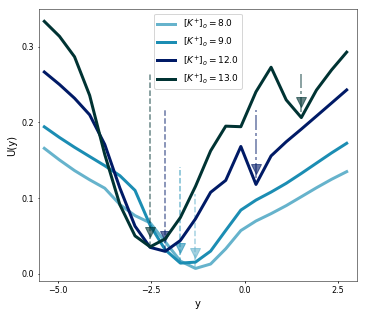

In [22]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)

iii=0
for K_o in koivv2:
    colorii=next(colors)
    if K_o in v_Ko_t:
        if v_Ko_t[iii]==8 or v_Ko_t[iii]==9 or v_Ko_t[iii]==12.0 or v_Ko_t[iii]==13.0:
            bi=m_hist_b_Uy[iii]
            Uy=m_hist_a_Uy[iii]
            ax.plot(bi[(bi>-5.5)*(bi<3)],Uy[(bi>-5.5)*(bi<3)], linewidth=3,label='$[K^{+}]_o=$'+str(v_Ko_t[iii]),color=colorii)
            ### Trying to distinguish attractors..
            att1=bi[bi<0][np.argmin(Uy[bi<0])]
            att2=bi[bi>0][np.argmin(Uy[bi>0])]

            ax.plot(np.ones(10)*att1,np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]/1.8),10),'--',color=colorii ,alpha=0.6)
            ax.plot(np.ones(1)*att1,np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10)[0]+0.02,marker='v',markersize=10,color=colorii ,alpha=0.6)

            if K_o>11.5:
                ax.plot(np.ones(10)*att2,np.linspace(min(Uy[bi>0]),max(Uy[bi>-5.5]/1.8),10),dashes=[2, 2, 10, 2],color=colorii,alpha=0.6)
                ax.plot(np.ones(1)*att2,np.linspace(min(Uy[bi>0]),max(Uy[bi>-5.5]),10)[0]+0.02,dashes=[2, 2, 10, 2],marker='v',markersize=10,color=colorii ,alpha=0.6)


        
        iii+=1

ax.legend()
# ax.set_title('U(y) for the network '+'Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+'[mM]',fontsize=size_axis_font)
ax.set_xlabel('y')
ax.set_ylabel('U(y)')

# ax.legend()
ax.set_xlim([-5.5,3])

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)


name_file='Uy_population_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Potential U of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)


No handles with labels found to put in legend.


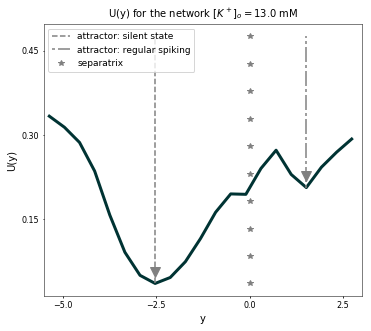

In [23]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)

iii=0
for K_o in koivv2:
    colorii=next(colors)
    if K_o in v_Ko_t:
        if v_Ko_t[iii]==13.0:
            bi=m_hist_b_Uy[iii]
            Uy=m_hist_a_Uy[iii]
            ax.plot(bi[(bi>-5.5)*(bi<3)],Uy[(bi>-5.5)*(bi<3)], linewidth=3,color=colorii)
            ax.set_title('U(y) for the network '+'$[K^+]_o=$'+str(v_Ko_t[iii])+' mM')
        iii+=1

ax.legend()
# ax.set_title('U(y) for the network '+'Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+'[mM]',fontsize=size_axis_font)
ax.set_xlabel('y')
ax.set_ylabel('U(y)')


ax.set_xlim([-5.5,3])

att1=bi[bi<0][np.argmin(Uy[bi<0])]
att2=bi[bi>0][np.argmin(Uy[bi>0])]
Pot_i=np.argmax(Uy[(bi>att1)*(bi<att2)])

ax.plot(np.ones(10)*att1,np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10),'--',color='grey' ,label='attractor: silent state')
ax.plot(np.ones(1)*att1,np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10)[0]+0.02,marker='v',markersize=10,color='grey')

ax.plot(np.ones(10)*att2,np.linspace(min(Uy[bi>0]),max(Uy[bi>-5.5]),10),dashes=[2, 2, 10, 2],color='grey' ,label='attractor: regular spiking')
ax.plot(np.ones(1)*att2,np.linspace(min(Uy[bi>0]),max(Uy[bi>-5.5]),10)[0]+0.02,dashes=[2, 2, 10, 2],marker='v',markersize=10,color='grey')

ax.plot(np.zeros(10),np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10),'*',color='grey' ,label='separatrix')

# ax.plot(np.zeros(10),np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10),'-',color='grey' ,label='attractor: stochastic spiking')

ax.legend()
locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

name_file='Uy_Ko13_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Potential U of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)



In [24]:
fig_file_title

'fig_Uy_Ko13_4000_num_runs_1_lengthSim_20000_K_o_13_50_I_app_9ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_pres'

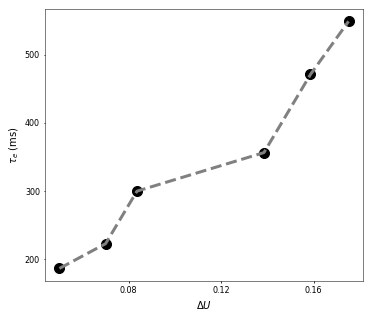

In [25]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

v_dUy=[]
t_m_mean_ISI=[]
for iii in range(len(m_hist_b_Uy)):
#     if v_Ko_t[iii]!=12.0:
    bi=m_hist_b_Uy[iii]
    Uy=m_hist_a_Uy[iii]
    dUy=Uy[np.argmin(abs(bi))]-Uy[np.argmin(Uy[bi<0])]
    v_dUy.append(dUy)
    t_m_mean_ISI.append(m_mean_ISI[iii])
#     ax.plot(bi,Uy, linewidth=3,label=str(v_Ko_t[iii]))

ax.plot(v_dUy,t_m_mean_ISI,'o',markersize=10,color='k')
ax.plot(v_dUy,t_m_mean_ISI,'--',linewidth=3,color='grey')

# ax.legend()
# ax.set_title('U(y) for the network '+'Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+'[mM]',fontsize=size_axis_font)
ax.set_xlabel(r'$\Delta U$')
ax.set_ylabel(r'$\tau_e$ (ms)')

# ax.legend()
# ax.set_xlim([-5.5,3])

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

name_file='dUy_vsT_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'dU vs tau e of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)



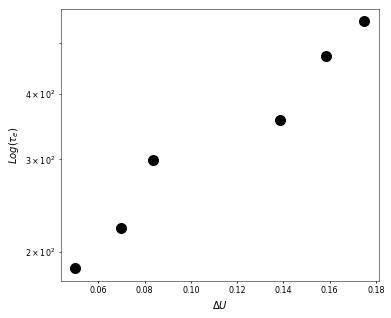

In [26]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

v_dUy=[]
t_m_mean_ISI=[]
v_sigi=[]
for iii in range(len(m_hist_b_Uy)):
    bi=m_hist_b_Uy[iii]
    Uy=m_hist_a_Uy[iii]
    isigi=m_sig_proj_Uy[iii]
    dUy=Uy[np.argmin(abs(bi))]-Uy[np.argmin(Uy[bi<0])]
    v_dUy.append(dUy)
    v_sigi.append(isigi)
    t_m_mean_ISI.append(m_mean_ISI[iii])


ax.semilogy(np.array(v_dUy),t_m_mean_ISI,'o',markersize=10,color='k')
ax.set_xlabel(r'$\Delta U$')
ax.set_ylabel(r'$Log(\tau_e)$')

# ax.legend()
# ax.set_xlim([-5.5,3])

# locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)
# locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
# ax.xaxis.set_major_locator(locatorx1)

name_file='dUy_vsT_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'dU vs tau e of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# # saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# # saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)




# m_sig_proj_Uy

In [27]:
np.shape(np.array(v_dUy)/np.array(v_sigi))

(6,)

In [28]:
np.shape(np.array(v_sigi))

(6,)

In [29]:
fig_file_title

'fig_dUy_vsT_4000_num_runs_1_lengthSim_20000_K_o_13_50_I_app_9ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_pres'

No handles with labels found to put in legend.


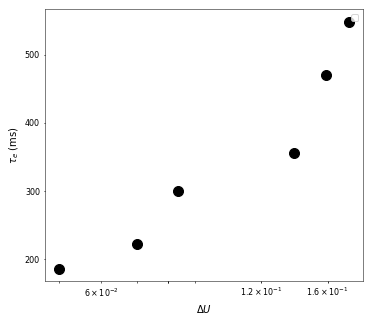

In [30]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

v_dUy=[]
for iii in range(len(m_hist_b_Uy)):
    bi=m_hist_b_Uy[iii]
    Uy=m_hist_a_Uy[iii]
    dUy=Uy[np.argmin(abs(bi))]-Uy[np.argmin(Uy[bi<0])]
    v_dUy.append(dUy)
#     ax.plot(bi,Uy, linewidth=3,label=str(v_Ko_t[iii]))

ax.semilogx(v_dUy,m_mean_ISI,'o',markersize=10,color='k')
ax.legend()
# ax.set_title('U(y) for the network '+'Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+'[mM]',fontsize=size_axis_font)
ax.set_xlabel(r'$\Delta U$')
ax.set_ylabel(r'$\tau_e$ (ms)')

# ax.legend()
# ax.set_xlim([-5.5,3])

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

name_file='logdUy_vsT_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'dU vs tau e of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)


In [31]:
fig_wide

5.7

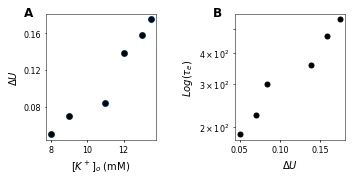

In [32]:
f20 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.6))

sx=6
sy=7
ax = plt.subplot2grid((9,17), (0, 0),colspan=sx,rowspan=sy)
ax1 = plt.subplot2grid((9,17), (0, 10),colspan=sx,rowspan=sy)



v_ko_tt=[]
v_dUy=[]
t_m_mean_ISI=[]
v_sigi=[]
for iii in range(len(m_hist_b_Uy)):
    bi=m_hist_b_Uy[iii]
    Uy=m_hist_a_Uy[iii]
    isigi=m_sig_proj_Uy[iii]
    dUy=Uy[np.argmin(abs(bi))]-Uy[np.argmin(Uy[bi<0])]
    v_dUy.append(dUy)
    v_ko_tt.append(v_Ko_t[iii])
    v_sigi.append(isigi)
    t_m_mean_ISI.append(m_mean_ISI[iii])


ax.plot(v_ko_tt,v_dUy,'o')
ax.plot(v_ko_tt,v_dUy,'o',markersize=5,color='k')

ax.set_xlabel(r'$[K^+]_o$ (mM)')
ax.set_ylabel(r'$\Delta U$ ')



ax1.semilogy(np.array(v_dUy),t_m_mean_ISI,'o',markersize=5,color='k')
ax1.set_xlabel(r'$\Delta U$')
ax1.set_ylabel(r'$Log(\tau_e)$')



locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

import string
for n, axs in enumerate([ax,ax1]):
    axs.text(-0.2, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')


name_file='Ko_vs_dUy_logtaue_dUy_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Ko vs dU vs tau e of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)


In [33]:
fig_file_title

'fig_Ko_vs_dUy_logtaue_dUy_4000_num_runs_1_lengthSim_20000_K_o_13_50_I_app_9ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_pres'